---
title: Sinusoidal Model (applied to the Sunspots Dataset)
---

We now look at another example for nonlinear regression. The following dataset is downloaded from https://www.sidc.be/SILSO/datafiles (silso stands for sunspot index and long term solar observations). Data description can be found here: https://www.sidc.be/SILSO/infosnytot. There are five columns:

1. Column 1 is the year (2020.5 refers to the year 2020 for example)
2. Column 2 is the yearly mean total sunspot number (this is obtained by taking a simple arithmetic mean of the daily sunspot number over all the days for that year)
3. Column 3 is the yearly mean standard deviation of the input sunspot numbers from individual stations (-1 indicates missing value)
4. Column 4 is the number of observations used to compute the yearly mean sunspot number (-1 indicates a missing value)
5. Column 5 is a definitive/provisional marker (1 indicates that the data point is definitive, and 0 indicates that it is still provisional)

We shall work with the data in column 2 (yearly mean total sunspot number). 

In [160]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [161]:
#annual sunspots dataset:
sunspots = pd.read_csv('SN_y_tot_V2.0.csv', header = None, sep = ';')
print(sunspots.head())
sunspots.columns = ['year', 'sunspotsmean', 'sunspotssd', 'sunspotsnobs', 'isdefinitive']
print(sunspots.head(10))

        0     1    2  3  4
0  1700.5   8.3 -1.0 -1  1
1  1701.5  18.3 -1.0 -1  1
2  1702.5  26.7 -1.0 -1  1
3  1703.5  38.3 -1.0 -1  1
4  1704.5  60.0 -1.0 -1  1
     year  sunspotsmean  sunspotssd  sunspotsnobs  isdefinitive
0  1700.5           8.3        -1.0            -1             1
1  1701.5          18.3        -1.0            -1             1
2  1702.5          26.7        -1.0            -1             1
3  1703.5          38.3        -1.0            -1             1
4  1704.5          60.0        -1.0            -1             1
5  1705.5          96.7        -1.0            -1             1
6  1706.5          48.3        -1.0            -1             1
7  1707.5          33.3        -1.0            -1             1
8  1708.5          16.7        -1.0            -1             1
9  1709.5          13.3        -1.0            -1             1


0     8.3
1    18.3
2    26.7
3    38.3
4    60.0
Name: sunspotsmean, dtype: float64


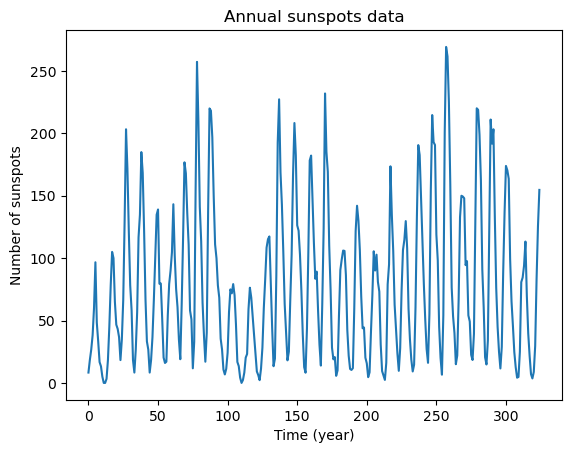

In [162]:
y = sunspots['sunspotsmean']
print(y.head())
plt.plot(y)
plt.xlabel('Time (year)')
plt.ylabel('Number of sunspots')
plt.title('Annual sunspots data')
plt.show()

We will fit the sinusoidal model: 
\begin{equation*}
  y_t = \beta_0 + \beta_1 \cos(2 \pi f t) + \beta_2 \sin(2 \pi f t) + \epsilon_t
\end{equation*}
with $\epsilon_t$ being i.i.d $N(0, \sigma^2)$. When $f$ is known, this is a linear regression model. We can fit this model to the data and see how good the fit is while varying $f$. This will give us an idea of which frequencies give good fits to the data. Later we shall consider $f$ as an unknown parameter and discuss estimation and inference for $f$. 

                            OLS Regression Results                            
Dep. Variable:           sunspotsmean   R-squared:                       0.132
Model:                            OLS   Adj. R-squared:                  0.127
Method:                 Least Squares   F-statistic:                     24.49
Date:                Thu, 18 Sep 2025   Prob (F-statistic):           1.26e-10
Time:                        22:46:41   Log-Likelihood:                -1778.8
No. Observations:                 325   AIC:                             3564.
Df Residuals:                     322   BIC:                             3575.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         78.8996      3.213     24.559      0.0

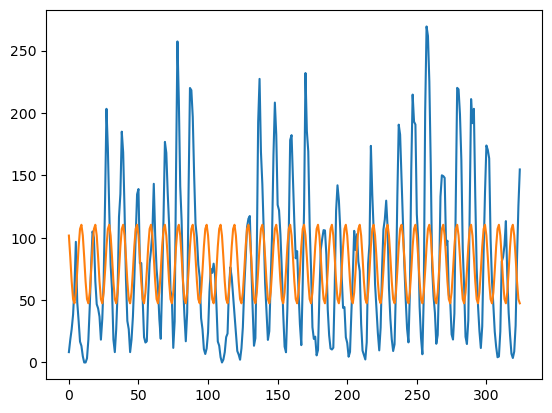

In [163]:
#Let us try some frequencies to get  intuition:
n = len(y)
x = np.arange(1, n+1)
f = 1/10
#f = 1/11 #wikipedia article on sunspots states that the sunspots periodicity is 11
#f = 1/4
#f = 1/15
sinvals = np.sin(2 * np.pi * f * x)
cosvals = np.cos(2 * np.pi * f * x)
X = np.column_stack([np.ones(n), sinvals, cosvals])
md = sm.OLS(y, X).fit()
print(md.summary())

plt.plot(y)
plt.plot(md.fittedvalues)
plt.show()


As before, we use RSS to calculate goodness of fit. We can vary over the values of $f$ and find the $f$ for which RSS is minimized. 

In [164]:
def rss(f):
    x = np.arange(1, n+1)
    xcos = np.cos(2 * np.pi * f * x)
    xsin = np.sin(2 * np.pi * f * x)
    X = np.column_stack([np.ones(n), xcos, xsin])
    md = sm.OLS(y, X).fit()
    rss = np.sum(md.resid ** 2)
    return rss

In [165]:
print(rss(1/15))
print(rss(1/4))
print(rss(1/11))
print(rss(1/10))

1235555.4316413044
1243980.0504058595
866129.2421378704
1079858.9542035519


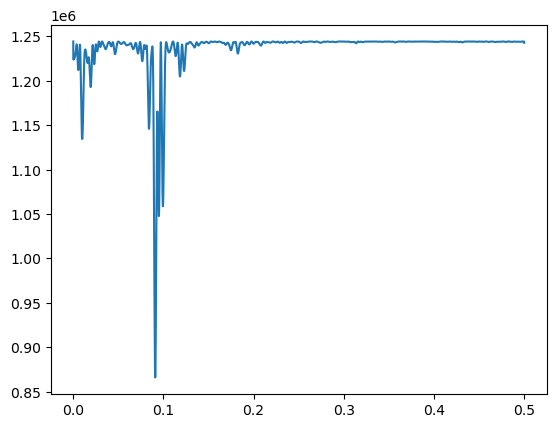

In [166]:
num_f_vals = 10000 #this is the number of different values of f we will try
allfvals = np.linspace(0, 0.5, num_f_vals)
rssvals = np.array([rss(f) for f in allfvals])
plt.plot(allfvals, rssvals)
plt.show()

In [167]:
fhat = allfvals[np.argmin(rssvals)]
print(fhat)
print(1/fhat) #this is the estimated periodicity in years

0.09090909090909091
11.0


To estimate $\beta_0, \beta_1, \beta_2$ and $\sigma$, we simply run linear regression with $f = \hat{f}$:

In [168]:
f = fhat
x = np.arange(1, n+1)
xcos = np.cos(2 * np.pi * f * x)
xsin = np.sin(2 * np.pi * f * x)
X = np.column_stack([np.ones(n), xcos, xsin])
md = sm.OLS(y, X).fit()
print(md.summary())
sighat = np.sqrt(np.sum(md.resid ** 2) / (n - 3))
print(md.params, sighat)

                            OLS Regression Results                            
Dep. Variable:           sunspotsmean   R-squared:                       0.304
Model:                            OLS   Adj. R-squared:                  0.299
Method:                 Least Squares   F-statistic:                     70.26
Date:                Thu, 18 Sep 2025   Prob (F-statistic):           4.76e-26
Time:                        22:46:47   Log-Likelihood:                -1742.9
No. Observations:                 325   AIC:                             3492.
Df Residuals:                     322   BIC:                             3503.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         78.8760      2.877     27.414      0.0

Let us now do uncertainty quantification for $f$. We use the posterior formula: 
\begin{align*}
  \text{posterior}(f) \propto I\{0 < f < 1/2 \} |X_f^T X_f|^{-1/2} \left(\frac{1}{RSS(f)} \right)^{(n-p)/2}
\end{align*}

In [169]:
def logpost(f):
    x = np.arange(1, n+1)
    xcos = np.cos(2 * np.pi * f * x)
    xsin = np.sin(2 * np.pi * f * x)
    X = np.column_stack([np.ones(n), xcos, xsin])
    p = X.shape[1]
    md = sm.OLS(y, X).fit()
    rss = np.sum(md.resid ** 2)
    sgn, log_det = np.linalg.slogdet(np.dot(X.T, X)) #sgn gives the sign of the determinant (in our case, this should 1)
    #log_det gives the logarithm of the absolute value of the determinant
    logval = ((p-n)/2) * np.log(rss) - (0.5)*log_det
    return logval

The main role in this calculation is played by the $RSS(f)$ term. The other term $|X_f^T X_f|^{-1/2}$ generally does not vary much with $f$. This is demonstrated below. 

In [170]:
def logpost_nodet(f): #here we are calculating the log posterior without the determinant term (just to see how much difference it makes)
    x = np.arange(1, n+1)
    xcos = np.cos(2 * np.pi * f * x)
    xsin = np.sin(2 * np.pi * f * x)
    X = np.column_stack([np.ones(n), xcos, xsin])
    p = X.shape[1]
    md = sm.OLS(y, X).fit()
    rss = np.sum(md.resid ** 2)
    sgn, log_det = np.linalg.slogdet(np.dot(X.T, X)) #sgn gives the sign of the determinant (in our case, this should 1)
    #log_det gives the logarithm of the absolute value of the determinant
    logval = ((p-n)/2) * np.log(rss) #- (0.5)*log_det #we drop the determinant term
    return logval

While evaluating the log-posterior, we remove values of $f$ that are too close to 0 or 0.5. 

In [171]:
allfvals_modified = allfvals[10:-10]
logpostvals = np.array([logpost(f) for f in allfvals_modified])
logpostvals_nodet = np.array([logpost_nodet(f) for f in allfvals_modified]) 

Below we plot the log-posterior with the determinant term (which is the correct formula), and without the determinant term. 

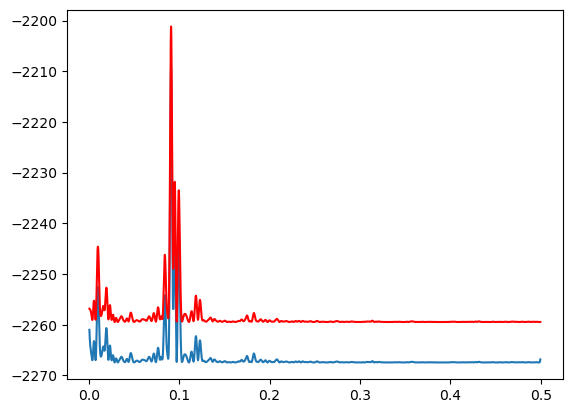

In [172]:
plt.plot(allfvals_modified, logpostvals)
plt.plot(allfvals_modified, logpostvals_nodet, color = 'red')
plt.show()


The two curves above look largely parallel (except for frequencies $f$ which are close to the endpoints). This suggests that the determinant has minimal impact on the posterior. Below we plot their difference.

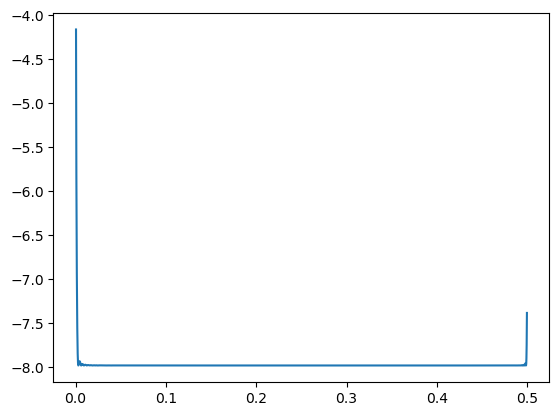

In [173]:
plt.plot(allfvals_modified, logpostvals - logpostvals_nodet)
plt.show()


Again the determinant term is only having an effect near the endpoints. This shows that the main term in the posterior is the term involving the RSS. 

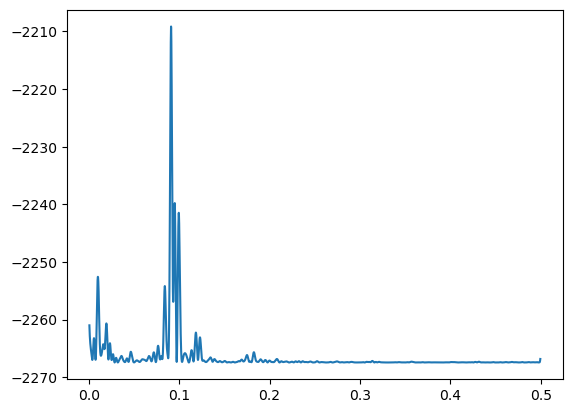

In [174]:
allfvals_modified = allfvals[10:-10]
logpostvals = np.array([logpost(f) for f in allfvals_modified])
postvals = np.exp(logpostvals - np.max(logpostvals))
postvals = postvals/(np.sum(postvals))
plt.plot(allfvals_modified, logpostvals)
plt.show()

The above plot looks similar to the plot of $RSS(f)$ (except it is upside down). The maximizer of the posterior density here is exactly the same as the MLE. 

In [175]:
print(allfvals_modified[np.argmax(postvals)])
print(allfvals[np.argmin(rssvals)])
print(1/allfvals_modified[np.argmax(postvals)])
print(1/allfvals[np.argmin(rssvals)])


0.09090909090909091
0.09090909090909091
11.0
11.0


Below we plot the posterior. This curve is much more peaked than the log posterior plot. In fact, only one peak is visible in the posterior. 

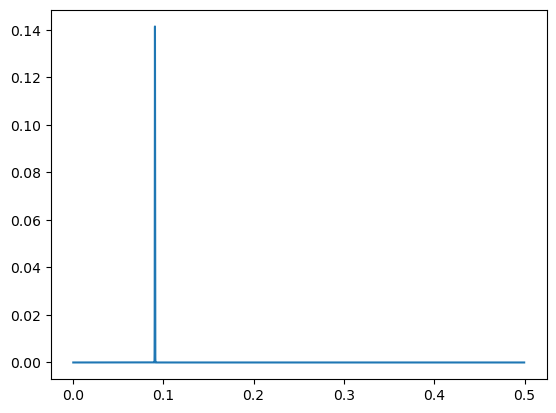

In [182]:
plt.plot(allfvals_modified, postvals)
plt.show()

Below we find 95\% Bayesian uncertainty interval for $f$. We calculate the posterior probability around the posterior maximizer, and keep expanding the region until the probability is 0.95. 

In [183]:
def PostProbAroundMax(m):
    est_ind = np.argmax(postvals)
    ans = np.sum(postvals[(est_ind-m):(est_ind+m+1)])
    return(ans)

In [184]:
print(PostProbAroundMax(0))
print(PostProbAroundMax(1))
print(PostProbAroundMax(6))


0.14143517124809554
0.4068681511534429
0.9779441017540897


In [ ]:
m = 6
est_ind = np.argmax(postvals)
f_est = allfvals_modified[est_ind]
#95% credible interval for f:
ci_f_low = allfvals_modified[est_ind - m]
ci_f_high = allfvals_modified[est_ind + m]
print(np.array([f_est, ci_f_low, ci_f_high])) #this is the 95% uncertainty interval for f

[0.09090909 0.09060906 0.09120912]


To get the interval for the period (which is the inverse of frequency), do the following. 

In [185]:
#For the period (1/frequency)
print(np.array([1/f_est, 1/ci_f_high, 1/ci_f_low]))

[11.         10.96381579 11.03642384]


This interval is highly concentrated around 11. The reason for such tight concentration is that $RSS(f)$ significantly increases even if $f$ changes slightly from 11. 

In [186]:
print(rss(1/11), rss(1/11.05), rss(1/10.95))

866129.2421378704 887294.206337193 891222.8998348333


The above clearly shows that the RSS increases significantly even if $f$ moves slightly away from $1/11$. This is the reason why we get such a narrow uncertainty interval for $f$ around $1/11$. 

## Efficient Computation of RSS(f) at Fourier Frequencies

Given a time series dataset $y_1, \dots, y_n$, the quantity $RSS(f)$ is defined by
\begin{equation*}
   RSS(f) := \min_{\beta_0, \beta_1, \beta_2} \sum_{t=1}^n \left(y_t - \beta_0 - \beta_1 \cos (2 \pi f t) - \beta_2 \sin(2 \pi f t) \right)^2
\end{equation*}
For each frequency $f$, $RSS(f)$ tells us how well the best sinusoid at frequency $f$ fits the data. This is used for identifying periodicities present in the data. 

Computing $RSS(f)$ for each $f$ in a grid (as above) can be quite time-consuming if the sample size $n$ is large. For example, consider the following audio dataset. The "Hear Piano Note - Middle C.mp3$ is an audio file consisting of about 14 seconds. It contains the sound of the Middle C note in the piano. The python library "Librosa" will be used for loading the audio file (see https://librosa.org/doc/latest/index.html for instructions on installing librosa, and tutorials etc.)

In [155]:
import librosa
y,sr=librosa.load("Hear Piano Note - Middle C.mp3")
n = len(y)
print(n)
print(sr)
print(n/sr)

301272
22050
13.66312925170068


This dataset has $n = 301272$ points. Clearly this is a time series dataset of a large size. The data (sound waveform) is plotted below.

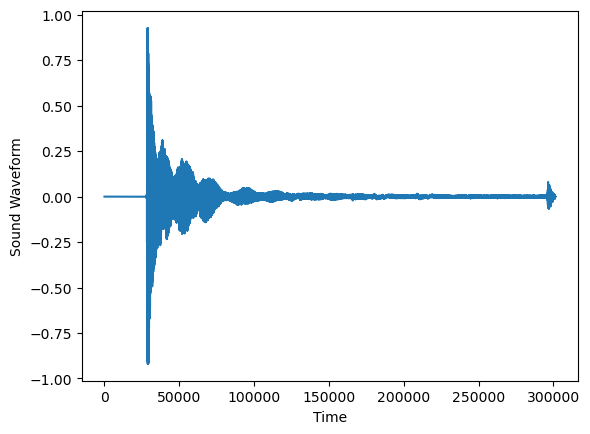

In [156]:
plt.plot(y)
plt.xlabel("Time")
plt.ylabel("Sound Waveform")
plt.show()

The full plot of the data is not very revealing as the data size is very long. But if we restrict to a smaller portion of the dataset, we can visualize the cyclical behavior more easily. 

Text(0, 0.5, 'Sound waveform')

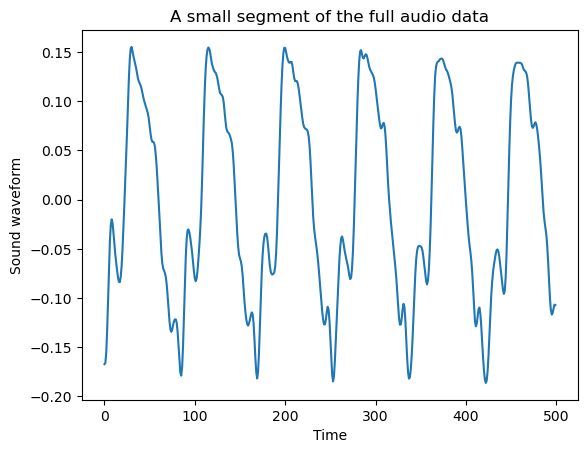

In [157]:
y_smallpart = y[50000:(50000 + 500)]
plt.plot(y_smallpart)
plt.xlabel('Time')
plt.title('A small segment of the full audio data')
plt.ylabel('Sound waveform')

In order to figure out the main frequencies present in the data, we can fit the sinusoidal model to this dataset. As before, we can compute $RSS(f)$ for each $f$ in a grid of frequencies in $[0, 1/2]$, and then find the best $f$ with the smallest $RSS(f)$. However this code will take way too long to run because of the large sample size. 

In [158]:
ngrid = 10000
allfvals = np.linspace(0, 0.5, ngrid)
rssvals = np.array([rss(f) for f in allfvals])
plt.plot(allfvals, rssvals)

KeyboardInterrupt: 

In the next lecture, we shall see how to compute the RSS much more efficiently at the Fourier frequencies $f$ ($f$ is a Fourier frequency if $nf$ is an integer). The basic formula is as follows. Recall first that, given a time series dataset $y_1, \dots, y_n$, the quantity $RSS(f)$ is defined by
\begin{equation*}
   RSS(f) := \min_{\beta_0, \beta_1, \beta_2} \sum_{t=1}^n \left(y_t - \beta_0 - \beta_1 \cos (2 \pi f t) - \beta_2 \sin(2 \pi f t) \right)^2
\end{equation*}
For each frequency $f$, $RSS(f)$ tells us how well the best sinusoid at frequency $f$ fits the data. 

The following is an alternative formula for $RSS(f)$ which holds when $f \in (0, 1/2)$ is a Fourier frequency (i.e., $nf$ is an integer):
\begin{equation*}
   RSS(f) = \sum_{t} (y_t - \bar{y})^2 - 2I(f)
\end{equation*}
where
\begin{equation*}
   I(f) := \frac{1}{n} \left| \sum_{t=1}^n y_t e^{-2 \pi i f t} \right|^2
\end{equation*}
is called the Periodogram. The quantity
\begin{equation*}
 \sum_{t=1}^n y_t e^{-2 \pi i f t} 
\end{equation*}
when $f$ varies over the Fourier frequencies in $(0, 1/2)$ is called the Discrete Fourier Transform (DFT) of the data $y_1, \dots, y_n$. An efficient algorithm called FFT (Fast Fourier Transform) allows fast computation of the DFT. We shall discuss the DFT in more detail in the next lecture, and see how it can be used to compute $RSS(f)$ efficiently at Fourier frequencies $f$. 